In [9]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from emoji import demojize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.decomposition import LatentDirichletAllocation

In [10]:
# Définition des tweets et des catégories
tweets = [
    "J'adore le football et la Ligue des Champions est incroyable ! #UCL #Football",
    "Le Bitcoin a encore explosé cette semaine, faut-il investir ? #Crypto #BTC",
    "Les voitures électriques vont dominer le marché automobile. #Tesla #EV",
    "Quel est le meilleur téléphone en 2025 ? #Tech #Smartphone",
    "L'intelligence artificielle est en train de révolutionner le monde. #AI #Tech",
    "Netflix sort une nouvelle série demain, hâte de voir ça ! #Netflix #Streaming",
    "Elon Musk vient d'annoncer une nouvelle mise à jour pour Tesla. #Tesla #Tech",
    "La bourse est en chute libre aujourd'hui, inquiétant ! #Finance #Trading",
    "Les montres connectées sont devenues un must-have en 2025. #Tech #Wearables",
    "Quel est le top 10 des livres à lire absolument cette année ? #Books #Reading"
]

categories = ['Sport', 'Finance', 'Tech', 'Tech', 'Tech',
             'Entertainment', 'Tech', 'Finance', 'Tech', 'Culture']

# Génération des données
usernames = [f"user_{i}" for i in range(1, len(tweets) + 1)]
retweets = [random.randint(10, 1000) for _ in range(len(tweets))]
likes = [random.randint(50, 5000) for _ in range(len(tweets))]
timestamps = [(datetime.now() - timedelta(days=random.randint(1, 365))).strftime("%Y-%m-%d %H:%M:%S")
             for _ in range(len(tweets))]

# Création du DataFrame
df_tweets = pd.DataFrame({
    "Tweet_ID": range(1, len(tweets) + 1),
    "Username": usernames,
    "Text": tweets,
    "Category": categories,
    "Retweets": retweets,
    "Likes": likes,
    "Timestamp": timestamps
})
df_tweets['Timestamp'] = pd.to_datetime(df_tweets['Timestamp'])

In [11]:
# Téléchargement des ressources NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_tweet(text):
    """Fonction de prétraitement des tweets"""
    # Conversion en minuscules
    text = text.lower()

    # Suppression des URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Suppression des mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Conservation des hashtags pour la recommandation

    # Suppression des caractères spéciaux et des chiffres
    text = re.sub(r'[^\w\s#]', '', text)

    return text

# Application du prétraitement
df_tweets['Text_Clean'] = df_tweets['Text'].apply(preprocess_tweet)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/barrysalam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/barrysalam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/barrysalam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/barrysalam/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
def get_recommendations(df_tweets, selected_hashtags=None, selected_categories=None, n_recommendations=5):
   
    df_filtered = df_tweets.copy()

    # Création d'un score initial basé sur l'engagement
    df_filtered['score'] = df_filtered['Likes'] + (df_filtered['Retweets'] * 2)

    # Filtrage par hashtags si spécifié
    if selected_hashtags and len(selected_hashtags) > 0:
        hashtag_mask = df_filtered['Text'].str.contains('|'.join(selected_hashtags), case=False)
        df_filtered.loc[hashtag_mask, 'score'] *= 1.5

    # Filtrage par catégories si spécifié
    if selected_categories and len(selected_categories) > 0:
        df_filtered = df_filtered[df_filtered['Category'].isin(selected_categories)]

    # Tri par score et sélection des meilleures recommandations
    recommendations = df_filtered.sort_values('score', ascending=False).head(n_recommendations)

    return recommendations[['Text', 'Category', 'Likes', 'Retweets', 'score']]

In [13]:
def extract_hashtags(text):
    """Extrait les hashtags d'un texte"""
    return re.findall(r'#(\w+)', text)

def create_recommendation_interface(df):
    # Extraction de tous les hashtags uniques
    all_hashtags = set()
    for text in df['Text']:
        all_hashtags.update(extract_hashtags(text))
    all_hashtags = list(all_hashtags)

    # Création des widgets
    hashtag_selector = widgets.SelectMultiple(
        options=all_hashtags,
        description='Hashtags:',
        rows=5
    )

    category_selector = widgets.SelectMultiple(
        options=df['Category'].unique(),
        description='Catégories:',
        rows=5
    )

    n_recommendations = widgets.IntSlider(
        value=5,
        min=1,
        max=10,
        description='Nombre:'
    )

    output = widgets.Output()

    def on_change(change):
        with output:
            clear_output()
            selected_hashtags = hashtag_selector.value
            recommendations = get_recommendations(
                df,
                selected_hashtags=selected_hashtags,
                selected_categories=category_selector.value,
                n_recommendations=n_recommendations.value
            )
            display(recommendations)

    hashtag_selector.observe(on_change, names='value')
    category_selector.observe(on_change, names='value')
    n_recommendations.observe(on_change, names='value')

    # Affichage de l'interface
    display(widgets.VBox([
        widgets.HBox([hashtag_selector, category_selector]),
        n_recommendations,
        output
    ]))

# Lancement de l'interface
create_recommendation_interface(df_tweets)

In [14]:
# Vectorisation du texte
vectorizer = CountVectorizer(max_df=0.7, min_df=1, stop_words=list(stopwords.words('french')))
X = vectorizer.fit_transform(df_tweets['Text_Clean'])

# K-means avec 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
df_tweets['Cluster'] = kmeans.fit_predict(X)

# Affichage des résultats par cluster
for cluster in range(4):
    print(f"\nCluster {cluster}:")
    cluster_tweets = df_tweets[df_tweets['Cluster'] == cluster]
    print(f"Nombre de tweets : {len(cluster_tweets)}")
    print("Catégories dans ce cluster:")
    print(cluster_tweets['Category'].value_counts())
    print("\nExemples de tweets:")
    print(cluster_tweets['Text'].iloc[0])


Cluster 0:
Nombre de tweets : 1
Catégories dans ce cluster:
Entertainment    1
Name: Category, dtype: int64

Exemples de tweets:
Netflix sort une nouvelle série demain, hâte de voir ça ! #Netflix #Streaming

Cluster 1:
Nombre de tweets : 2
Catégories dans ce cluster:
Finance    1
Culture    1
Name: Category, dtype: int64

Exemples de tweets:
Le Bitcoin a encore explosé cette semaine, faut-il investir ? #Crypto #BTC

Cluster 2:
Nombre de tweets : 6
Catégories dans ce cluster:
Tech       4
Sport      1
Finance    1
Name: Category, dtype: int64

Exemples de tweets:
J'adore le football et la Ligue des Champions est incroyable ! #UCL #Football

Cluster 3:
Nombre de tweets : 1
Catégories dans ce cluster:
Tech    1
Name: Category, dtype: int64

Exemples de tweets:
Elon Musk vient d'annoncer une nouvelle mise à jour pour Tesla. #Tesla #Tech


In [15]:
# Configuration du LDA
count_vectorizer = CountVectorizer(
    max_df=0.7,
    min_df=1,
    stop_words=list(stopwords.words('french')),  # Utilisation directe des stop words de NLTK
    max_features=50,
    ngram_range=(1, 2)
)

lda_model = LatentDirichletAllocation(
    n_components=3,
    random_state=42,
    max_iter=100,
    learning_method='online',
    learning_offset=50.,
    doc_topic_prior=0.01,
    topic_word_prior=0.01
)

# Application du LDA
doc_term_matrix = count_vectorizer.fit_transform(df_tweets['Text_Clean'])
lda_output = lda_model.fit_transform(doc_term_matrix)

# Fonction d'affichage des topics
def print_topics_and_tweets(model, feature_names, df_tweets, n_top_words=5):
    print("Topics principaux et leurs mots clés :")

    topic_predictions = model.transform(doc_term_matrix)
    df_tweets['Topic_Dominant'] = topic_predictions.argmax(axis=1)

    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1} :")
        print("=" * 50)

        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [topic[i] for i in top_words_idx]

        for word, weight in zip(top_words, top_weights):
            print(f"- {word:<30} {weight:.4f}")

        print("\nTweets associés à ce topic:")
        topic_tweets = df_tweets[df_tweets['Topic_Dominant'] == topic_idx]
        for _, tweet in topic_tweets.iterrows():
            print(f"- {tweet['Text']} (Catégorie: {tweet['Category']})")
        print("-" * 50)

# Affichage des résultats
feature_names = count_vectorizer.get_feature_names()
print_topics_and_tweets(lda_model, feature_names, df_tweets)

Topics principaux et leurs mots clés :

Topic 1 :
- football                       1.9965
- tesla                          1.9954
- mise jour                      1.0119
- semaine fautil                 1.0113
- vient dannoncer                1.0110

Tweets associés à ce topic:
- J'adore le football et la Ligue des Champions est incroyable ! #UCL #Football (Catégorie: Sport)
- Le Bitcoin a encore explosé cette semaine, faut-il investir ? #Crypto #BTC (Catégorie: Finance)
- Elon Musk vient d'annoncer une nouvelle mise à jour pour Tesla. #Tesla #Tech (Catégorie: Tech)
- La bourse est en chute libre aujourd'hui, inquiétant ! #Finance #Trading (Catégorie: Finance)
--------------------------------------------------

Topic 2 :
- netflix                        1.9965
- musthave                       1.0135
- vont dominer                   1.0125
- 2025 tech                      1.0121
- nouvelle                       1.0118

Tweets associés à ce topic:
- Les voitures électriques vont dominer 

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

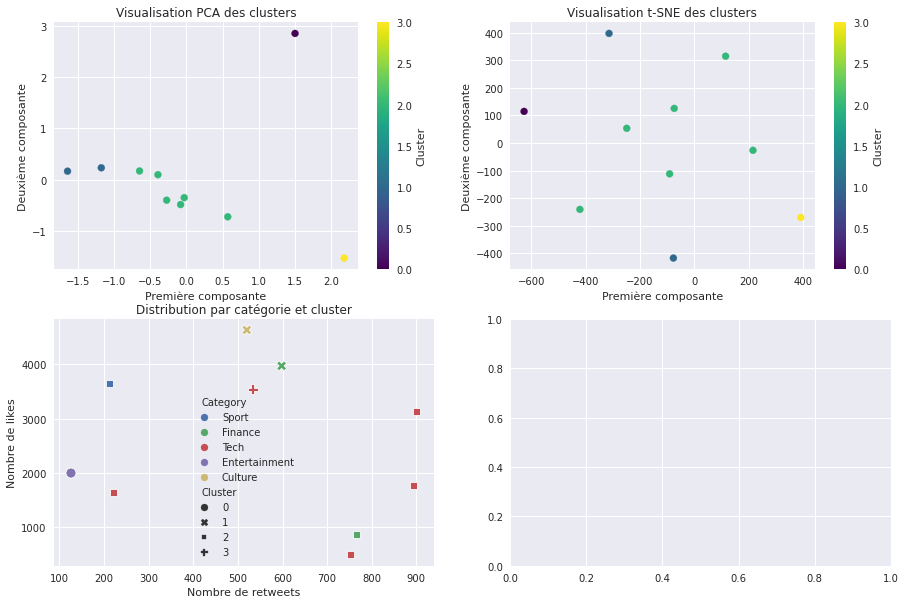

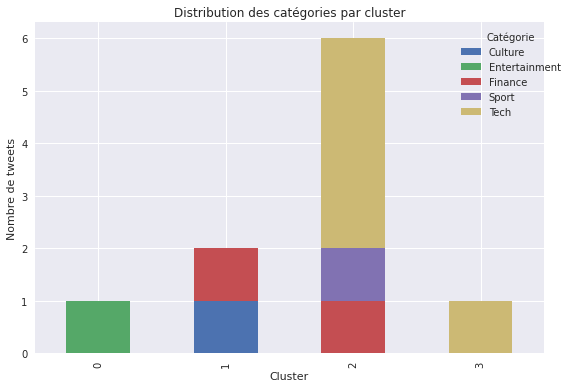


Statistiques par cluster :

Cluster 0:
Nombre de tweets : 1
Catégories :
Entertainment    1
Name: Category, dtype: int64
Engagement moyen :
- Likes : 1995.0
- Retweets : 126.0

Cluster 1:
Nombre de tweets : 2
Catégories :
Finance    1
Culture    1
Name: Category, dtype: int64
Engagement moyen :
- Likes : 4301.0
- Retweets : 559.0

Cluster 2:
Nombre de tweets : 6
Catégories :
Tech       4
Sport      1
Finance    1
Name: Category, dtype: int64
Engagement moyen :
- Likes : 1920.8
- Retweets : 624.3

Cluster 3:
Nombre de tweets : 1
Catégories :
Tech    1
Name: Category, dtype: int64
Engagement moyen :
- Likes : 3537.0
- Retweets : 533.0


In [19]:
# Configuration de la visualisation
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'DejaVu Sans'

# PCA et t-SNE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne = tsne.fit_transform(X.toarray())

# Création des visualisations
fig = plt.figure(figsize=(15, 10))

# Visualisation PCA
plt.subplot(221)
scatter1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_tweets['Cluster'], cmap='viridis')
plt.title('Visualisation PCA des clusters')
plt.xlabel('Première composante')
plt.ylabel('Deuxième composante')
plt.colorbar(scatter1, label='Cluster')

# Visualisation t-SNE
plt.subplot(222)
scatter2 = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_tweets['Cluster'], cmap='viridis')
plt.title('Visualisation t-SNE des clusters')
plt.xlabel('Première composante')
plt.ylabel('Deuxième composante')
plt.colorbar(scatter2, label='Cluster')

# Distribution par catégorie et engagement
plt.subplot(223)
sns.scatterplot(
    data=df_tweets,
    x='Retweets',
    y='Likes',
    hue='Category',
    style='Cluster',
    s=100
)
plt.title('Distribution par catégorie et cluster')
plt.xlabel('Nombre de retweets')
plt.ylabel('Nombre de likes')

# Distribution des catégories par cluster
plt.subplot(224)
cluster_category = pd.crosstab(df_tweets['Cluster'], df_tweets['Category'])
cluster_category.plot(kind='bar', stacked=True)
plt.title('Distribution des catégories par cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre de tweets')
plt.legend(title='Catégorie', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Statistiques par cluster
print("\nStatistiques par cluster :")
for cluster in range(len(df_tweets['Cluster'].unique())):
    cluster_data = df_tweets[df_tweets['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Nombre de tweets : {len(cluster_data)}")
    print("Catégories :")
    print(cluster_data['Category'].value_counts())
    print("Engagement moyen :")
    print(f"- Likes : {cluster_data['Likes'].mean():.1f}")
    print(f"- Retweets : {cluster_data['Retweets'].mean():.1f}")

In [20]:
# Test 1 : Recommandations basées sur un hashtag Tech
print("Test 1 : Recommandations pour #Tech")
print("-" * 50)
recommendations_tech = get_recommendations(
    df_tweets,
    selected_hashtags=['#Tech'],
    n_recommendations=3
)
display(recommendations_tech)

# Test 2 : Recommandations pour Finance
print("\nTest 2 : Recommandations pour la catégorie Finance")
print("-" * 50)
recommendations_finance = get_recommendations(
    df_tweets,
    selected_categories=['Finance'],
    n_recommendations=3
)
display(recommendations_finance)

Test 1 : Recommandations pour #Tech
--------------------------------------------------


,Text,Category,Likes,Retweets,score
6,Elon Musk vient d'annoncer une nouvelle mise à...,Tech,3537,533,6904.5
9,Quel est le top 10 des livres à lire absolumen...,Culture,4632,520,5672.0
4,L'intelligence artificielle est en train de ré...,Tech,1762,893,5322.0



Test 2 : Recommandations pour la catégorie Finance
--------------------------------------------------


,Text,Category,Likes,Retweets,score
1,"Le Bitcoin a encore explosé cette semaine, fau...",Finance,3970,598,5166
7,"La bourse est en chute libre aujourd'hui, inqu...",Finance,860,766,2392


In [21]:
def test_recommendations():
    # Création des widgets
    hashtag_input = widgets.Text(
        value='',
        placeholder='Entrez un hashtag (ex: #Tech)',
        description='Hashtag:',
        disabled=False
    )

    category_dropdown = widgets.Dropdown(
        options=df_tweets['Category'].unique(),
        description='Catégorie:',
        disabled=False
    )

    button = widgets.Button(description='Obtenir recommandations')
    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output()
            hashtags = [hashtag_input.value] if hashtag_input.value else None
            categories = [category_dropdown.value] if category_dropdown.value else None

            recommendations = get_recommendations(
                df_tweets,
                selected_hashtags=hashtags,
                selected_categories=categories,
                n_recommendations=3
            )

            print(f"Recommandations pour {hashtags} et {categories}:")
            display(recommendations)

    button.on_click(on_button_click)

    # Affichage des widgets
    display(widgets.VBox([
        hashtag_input,
        category_dropdown,
        button,
        output
    ]))

# Lancer l'interface de test
print("Interface de test des recommandations")
test_recommendations()

Interface de test des recommandations


In [22]:
def test_multiple_scenarios():
    # Scénario 1: Tech + Finance
    print("Scénario 1: Tech + Finance")
    print("-" * 50)
    recommendations_1 = get_recommendations(
        df_tweets,
        selected_hashtags=['#Tech'],
        selected_categories=['Finance'],
        n_recommendations=2
    )
    display(recommendations_1)

    # Scénario 2: Multiple hashtags
    print("\nScénario 2: Multiple hashtags (#AI, #Tech)")
    print("-" * 50)
    recommendations_2 = get_recommendations(
        df_tweets,
        selected_hashtags=['#AI', '#Tech'],
        n_recommendations=2
    )
    display(recommendations_2)

    # Scénario 3: Catégories uniquement
    print("\nScénario 3: Tech et Entertainment")
    print("-" * 50)
    recommendations_3 = get_recommendations(
        df_tweets,
        selected_categories=['Tech', 'Entertainment'],
        n_recommendations=2
    )
    display(recommendations_3)

# Lancer les tests multiples
test_multiple_scenarios()

Scénario 1: Tech + Finance
--------------------------------------------------


,Text,Category,Likes,Retweets,score
1,"Le Bitcoin a encore explosé cette semaine, fau...",Finance,3970,598,5166.0
7,"La bourse est en chute libre aujourd'hui, inqu...",Finance,860,766,2392.0



Scénario 2: Multiple hashtags (#AI, #Tech)
--------------------------------------------------


,Text,Category,Likes,Retweets,score
6,Elon Musk vient d'annoncer une nouvelle mise à...,Tech,3537,533,6904.5
9,Quel est le top 10 des livres à lire absolumen...,Culture,4632,520,5672.0



Scénario 3: Tech et Entertainment
--------------------------------------------------


,Text,Category,Likes,Retweets,score
2,Les voitures électriques vont dominer le march...,Tech,3126,901,4928
6,Elon Musk vient d'annoncer une nouvelle mise à...,Tech,3537,533,4603
